In [ ]:
%%bash
# 安装python依赖
pip install grpcio grpcio-tools requests
pip install numpy matplotlib

# 生产grpc的proto文件
cat > StockChange.proto <<EOF
syntax = "proto3";

service Greeter {
  // 定义一个简单的 RPC 方法
  rpc StockChange (StockRequest) returns (StockReply);
}

// 定义请求和响应消息
message StockRequest {
  string id = 1;
  string name = 2;
  double price= 3;
  string reason = 4;
}

message StockReply {
  int32 code = 1;
  string body = 2;
}
EOF

# 生产grpc代码
python -m grpc_tools.protoc -I. --python_out=. --grpc_python_out=. StockChange.proto

### grpc服务端

代码运行于windows环境，主要作用是用于向桌面发送通知
构建windows环境的步骤如下：

1. 按键win+R，输入cmd
2. 创建python虚拟环境，输入python3 -m venv stock
3. 激活python虚拟环境，stock\Scripts\activate
4. 安装依赖pip install grpcio grpcio-tools
5. 生成文件StockChange.proto， 内容如下

```
syntax = "proto3";

service Greeter {
  // 定义一个简单的 RPC 方法
  rpc StockChange (StockRequest) returns (StockReply);
}

// 定义请求和响应消息
message StockRequest {
  string id = 1;
  string name = 2;
  double price= 3;
  string reason = 4;
}

message StockReply {
  int32 code = 1;
  string body = 2;
}
```
6. 生成rpc代码python -m grpc_tools.protoc -I. --python_out=. --grpc_python_out=. StockChange.proto
7. 生成文件stock_notify.py, 内容跟如下：

```python
import grpc
from concurrent import futures
import time
from plyer import notification


import stock_notify_pb2
import stock_notify_pb2_grpc

# 实现 Greeter 服务
class GreeterServicer(stock_notify_pb2_grpc.GreeterServicer):
    def StockChange(self, request, context):
        sotck_id = request.id
        stock_name = request.name
        stock_price = request.price
        request_reason = request.reason

        notify_title = f"股票{stock_name}当前价格{stock_price}"
        notify_msg = f"{request_reason}"

        notification.notify(title=notify_title,message=notify_msg,timeout=10)
        return stock_notify_pb2.StockReply(code=0, body="已发出通知")

def serve():
    server = grpc.server(futures.ThreadPoolExecutor(max_workers=10))

    stock_notify_pb2_grpc.add_GreeterServicer_to_server(GreeterServicer(), server)

    # 绑定服务到一个端口（例如 50051）
    server.add_insecure_port('0.0.0.0:50051')

    print("Server starting...")
    server.start()

    try:
        while True:
            time.sleep(86400)  # 让服务器持续运行
    except KeyboardInterrupt:
        server.stop(0)

if __name__ == '__main__':
    serve()
```

8. 运行服务端代码， python stock_notify.py

In [12]:
# grpc客户端代码
import grpc
import StockChange_pb2
import StockChange_pb2_grpc

def stock_notify(id, name, price, reason="没事"):
    channel = grpc.insecure_channel('172.31.128.1:50051')
    stub = StockChange_pb2_grpc.GreeterStub(channel)
    
    request = StockChange_pb2.StockRequest(id=id,
                                          name=name,
                                          price=price,
                                          reason=reason)
    
    response = stub.StockChange(request)
    print(f"gRPC 调用结果： {response.body}")

#stock_notify(id="xxx", name="xxxx", price=9.0)

gRPC 调用结果： 已发出通知


当前时间:2025-02-28 11:30, 洛阳钼业股价:6.69


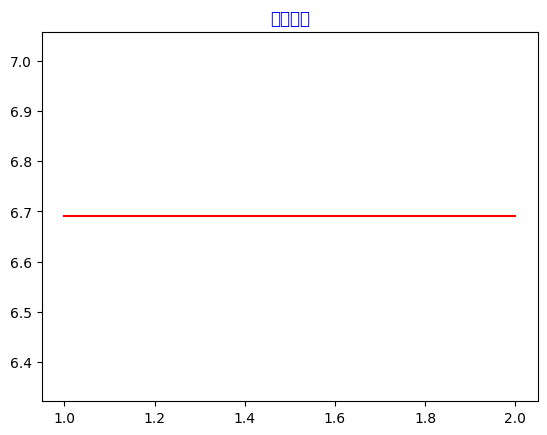

In [ ]:
import requests
import json
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
from functools import reduce


def get_stock_url(stock_code):
    stock_exchange = {
        "0": "sz",
        "1": "sh"
        }
    ex_key, code = stock_code.split(".")
    base_url = 'https://29.push2.eastmoney.com/api/qt/stock/trends2/sse'
    query_params = {
        "fields1": "f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f17",
        "fields2": "f51,f52,f53,f54,f55,f56,f57,f58",
        "mpi": "1000",
        "ut": "fa5fd1943c7b386f172d6893dbfba10b",
        "secid": f"{stock_code}",
        "ndays": 1,
        "iscr": 0,
        "iscca": 0,
        "wbp2u": "|0|0|0|web"
        }
    query_string = reduce(lambda x,y:str(x)+'&'+str(y), map(lambda x:str(x)+'='+str(query_params.get(x, '')), query_params))
    url = f"{base_url}?{query_string}"
    headers = {
        'Accept': 'text/event-stream',
        'Accept-Language':  'zh-CN,zh;q=0.9,en;q=0.8,en-GB;q=0.7,en-US;q=0.6',
        'Cache-Control':  'no-cache',
        'Connection':  'keep-alive',
        'Origin':  'https://quote.eastmoney.com',
        'Referer':  f'https://quote.eastmoney.com/{stock_exchange[ex_key]}{code}.html',
        'Sec-Fetch-Dest':  'empty',
        'Sec-Fetch-Mode':  'cors',
        'Sec-Fetch-Site':  'same-site',
        'User-Agent':  'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/133.0.0.0 Safari/537.36 Edg/133.0.0.0',
        'sec-ch-ua':  '"Not(A:Brand";v="99", "Microsoft Edge";v="133", "Chromium";v="133"',
        'sec-ch-ua-mobile':  '?0',
        'sec-ch-ua-platform':  '"Windows"'
        }
    return url, headers

def notify_1(id, name, price):
    low_level = 6.6
    high_level = 7.1
    if float(price) < low_level:
        reason = f"股价低于{low_level}，可能的买入点已形成"
        stock_notify(id, name, float(price), reason)
    if float(price) > high_level:
        reason = f"股价超过{high_level}， 达到潜在的卖出点"
        stock_notify(id, name, float(price), reason)
    


def output(name='', current='', price=''):
    global i, x_data, y_data
    fig, ax = plt.subplots()
    
    clear_output(wait=True)
    print(f"当前时间:{current}, {name}股价:{price}")
    i += 1
    x_data.append(i)
    y_data.append(float(price))
    # print(f"x:{x_data}, y:{y_data}")
    ax.plot(x_data, y_data, 'r-')
    plt.title(f"{name}", fontsize=12, color='blue', fontweight='bold')
    display(fig)

def parse_data(message):
    global name
    data = json.loads(message)
    # print(data)
    stock_data = data.get("data", {}) or {}
    if stock_data.get("name"):
        name = stock_data.get("name")
    code = stock_data.get("code") or ''
    trends_datas = stock_data.get("trends")
    if trends_datas:
        # print(trends_datas)
        current = trends_datas[-1].split(',')[0]
        price = trends_datas[-1].split(',')[1]
        output(name, current, price)
        notify_1(code, name, price)

def get_stock_data(stock_code):
    url, headers = get_stock_url(stock_code)
    with requests.get(url, stream=True, headers=headers) as response:
        if response.status_code == 200:
            for line in response.iter_lines():
                if line:
                    decoded_line = line.decode('utf-8')
                parse_data(decoded_line[5:])
        else:
            print(f"Failed to connect to server, status code: {response.status_code}")

"""
中公教育： 0.002607
洛阳钼业： 1.603993
"""

x_data = []
y_data = []
i = 0
name = ''

get_stock_data("1.603993")